## A.1. Find the most heated countries/areas

We collected data from the Berkeley Earth data webpage (http://berkeleyearth.lbl.gov/country-list/) 
using a webscraper script. The data are saved in a csv file: country_t_incr_list.csv


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import optimize
import codes
from codes import webscraper_country
from codes import webscraper_country_warming
from codes import webscraper

In [2]:
#use webscraper script to get the warming data for a list of 236 countries
webscraper_country_warming.output_country_t_incr_list()

In [3]:
df = pd.read_csv('./data_files/country_t_incr_list.csv')
display(df.head(4))

,Country,Warming_since_1960,Warming_since_1960_uncertainty,Region
0,afghanistan,3.32,0.34,Asia
1,åland,3.01,0.24,Europe
2,albania,1.97,0.28,Europe
3,algeria,2.86,0.28,Africa


In [4]:
df['Country']=df['Country'].str.capitalize() 
df_warm = df.copy().set_index('Country')
df_warm = df_warm.sort_values(by=['Warming_since_1960'], ascending = False).head(10)
display(df_warm)

,Warming_since_1960,Warming_since_1960_uncertainty,Region
Country,,,
Svalbard-and-jan-mayen,5.45,0.81,Europe
Canada,3.64,0.24,North America
Greenland,3.57,0.75,North America
Denmark,3.56,0.74,North America
Iran,3.52,0.37,Asia
Russia,3.39,0.28,Asia
United-arab-emirates,3.36,0.57,Asia
Afghanistan,3.32,0.34,Asia
Qatar,3.30,0.49,Asia


The above table shows the most heated countries since 1960. This list contains one country in Europe, three countries in North America, and six countries in Asia.

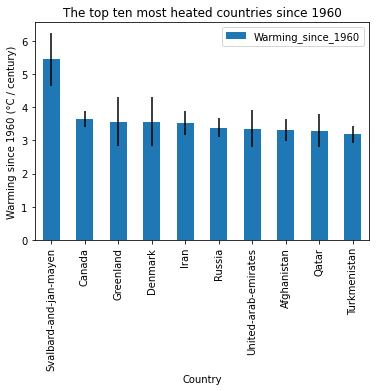

In [5]:
df_warm.plot(kind='bar', yerr='Warming_since_1960_uncertainty')
plt.ylabel('Warming since 1960 (°C / century)')
plt.title('The top ten most heated countries since 1960')
#plt.xticks(rotation = -50)
#plt.gca().set_aspect(0.8)
#fig.autofmt_xdate()
#plt.tight_layout()
plt.savefig('The_most_heated_countries.png',bbox_inches = "tight")

The table below shows the least heated countries since 1960. Even for those countries, their temperatures have increased at least 0.65 °C/century, which means global warming is happening all across the world.

In [6]:
df_warm2 = df.copy().set_index('Country')
df_warm2 = df_warm2.sort_values(by=['Warming_since_1960'], ascending = True).head(10)
display(df_warm2)

,Warming_since_1960,Warming_since_1960_uncertainty,Region
Country,,,
Bolivia,0.65,0.29,South America
Macau,0.79,0.29,Asia
Hong-kong,0.83,0.27,Asia
Bangladesh,0.90,0.41,Asia
Timor-leste,0.90,0.41,Asia
Vietnam,0.91,0.27,Asia
Palau,0.91,0.27,NaN
Peru,0.95,0.34,South America
Laos,0.96,0.28,Asia


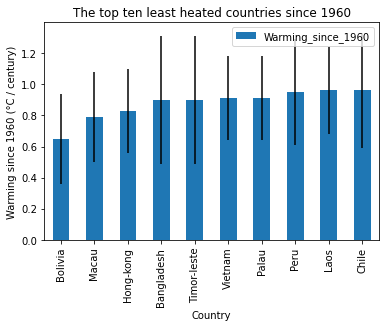

In [7]:
df_warm2.plot(kind='bar', yerr='Warming_since_1960_uncertainty')
plt.ylabel('Warming since 1960 (°C / century)')
plt.title('The top ten least heated countries since 1960')
#plt.xticks(rotation = -50)
#plt.gca().set_aspect(0.8)
#fig.autofmt_xdate()
#plt.tight_layout()
plt.savefig('The_least_heated_countries.png',bbox_inches = "tight")

## A.2. Analysis of the time series data for the most heated countries

Next, we conducted a detailed analysis of the time series data for the top 5 most heated countries and compared their results with global temperature data. Our research focused on temperature variation, heating rate, etc.

In [8]:
#use the webscraper script to download temperature data from Berkeley Earth website
#and get the absolute monthly temperature
from codes import webscraper_country_absoluteT
from codes import webscraper_absoluteT
#save data for the top 5 most heated countries into csv files
webscraper_country.generate_country_csv()
for country in df_warm.index[0:5].tolist():
    filename = str(country) +'_absoluteT.csv'
    !cp $filename ./data_files/ 
#save global temperature data 
!cp GlobalTemp_absoluteT.csv ./data_files/

In [9]:
#pre-process global temperature data
tempdata = pd.read_csv('./data_files/GlobalTemp_absoluteT.csv')
#combine Year/Month column into one Data column and only keep monthly anomaly
data_s = tempdata.loc[:,'Year':'Month'] 
data_s['Day'] = 1
tempdata = tempdata['Monthly_temperature'].to_frame()
tempdata['Location'] = 'Global'
tempdata['Date'] = pd.to_datetime(data_s)

In [10]:
def preprocess_counties(country):
    '''pre-process data for the top 5 most heated countries '''
    filename = './data_files/' + str(country) +'_absoluteT.csv'
    tempdata1 = pd.read_csv(filename)
    #combine Year/Month column into one Data column and only keep monthly anomaly
    data_s = tempdata1.loc[:,'Year':'Month'] 
    data_s['Day'] = 1
    tempdata1 = tempdata1['Monthly_temperature'].to_frame()
    tempdata1['Location'] = country
    tempdata1['Date'] = pd.to_datetime(data_s)
    return tempdata1
for country in df_warm.index[0:5].tolist():
    tempdata_country = preprocess_counties(country)
    tempdata = pd.concat([tempdata, tempdata_country])
tempdata.set_index('Date', inplace = True)
tempdata['year'] = tempdata.index.year
#only keep data starting from 1850 to match with time series data available for GHG emissions
tempdata = tempdata.loc['1850':]
tempdata

,Monthly_temperature,Location,year
Date,,,
1850-01-01,0.796,Global,1850
1850-02-01,3.193,Global,1850
1850-03-01,4.844,Global,1850
1850-04-01,7.168,Global,1850
1850-05-01,9.953,Global,1850
...,...,...,...
2020-08-01,29.462,Iran,2020
2020-09-01,25.354,Iran,2020
2020-10-01,18.501,Iran,2020


### A.2.1 Calculate the temperature variation for each country and the whole world.

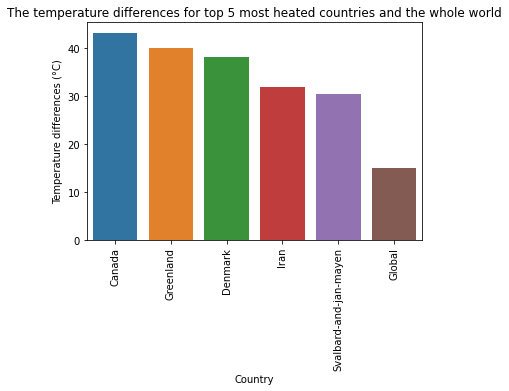

In [11]:
areas = tempdata['Location'].unique()

diff_list = []
for area in areas:
    temps = tempdata[tempdata['Location'] == area]['Monthly_temperature']
    diff_list.append(temps.max()-temps.min())
#rank the list by temperature variation
diff_list, areas = (list(x) for x in zip(*sorted(zip(diff_list, areas), \
                                                           key=lambda pair: pair[0], reverse=True)))
plt.figure(figsize=(6,4))
ax = sns.barplot(x = areas, y = diff_list)
plt.xticks(rotation = 'vertical')
ax.set(ylabel='Temperature differences (°C)', xlabel = 'Country', \
        title = 'The temperature differences for top 5 most heated countries and the whole world')
plt.savefig('The temperature differences for top 5 most heated countries and the whole world.png',bbox_inches = "tight")

In [12]:
diff_list

[43.257000000000005, 40.116, 38.25, 31.868000000000002, 30.385, 15.072]

In [13]:
#group by year for Global Temperature data
Global_df = tempdata[tempdata['Location'] == 'Global'].groupby('year').agg(
    max_temp=('Monthly_temperature', max),
    min_temp=('Monthly_temperature', min),
    mean_temp=('Monthly_temperature', "mean"),
    num_months=('Monthly_temperature', "count"))

#For the last year with temperature data, 12 month data may not be available, therefore delete 
#all data from that year
Global_df = Global_df[Global_df['num_months']==12]
Global_df

,max_temp,min_temp,mean_temp,num_months
year,,,,
1850,14.379,0.796,7.828917,12
1851,14.328,2.580,8.109917,12
1852,14.222,2.380,8.001167,12
1853,14.575,2.057,8.025750,12
1854,14.499,1.282,8.183333,12
...,...,...,...,...
2016,15.304,4.266,10.042583,12
2017,15.310,4.210,9.915583,12
2018,15.457,3.801,9.751000,12


In [14]:
#group by year and location for Temperature data
tempdata_year = tempdata.groupby(['year','Location']).agg(
    max_temp=('Monthly_temperature', max),
    min_temp=('Monthly_temperature', min),
    mean_temp=('Monthly_temperature', "mean"),
    num_months=('Monthly_temperature', "count"))

#For the last year with temperature data, 12 month data may not be available, therefore delete 
#all data from that year
tempdata_year1 = tempdata_year[tempdata_year['num_months']==12].unstack()
#reset_index() is very useful here
#but will use unstack to plot multiple locations on the same plot
tempdata_year1

max_temp                                                           \
Location   Canada Denmark  Global Greenland    Iran Svalbard-and-jan-mayen   
year                                                                         
1850       13.098  -2.199  14.379    -2.563  29.772                  3.865   
1851       12.634     NaN  14.328    -2.589  29.169                  5.725   
1852       13.006  -1.697  14.222    -2.041     NaN                  4.098   
1853          NaN  -1.631  14.575    -2.033     NaN                  5.216   
1854       12.793  -1.379  14.499    -1.739     NaN                  4.268   
...           ...     ...     ...       ...     ...                    ...   
2016       14.054  -0.142  15.304       NaN  31.093                    NaN   
2017       13.635  -2.046  15.310       NaN  30.829                    NaN   
2018       14.032  -2.717  15.457       NaN  31.937                    NaN   
2019       13.588  -0.097  15.464       NaN  31.691                    NaN   
2020       14.548  -1.478  15.484       NaN  30.937                    NaN   

         min_temp                           ...  mean_temp             \
Location   Canada Denmark Global Greenland  ...     Global  Greenland   
year                                        ...                         
1850      -23.667 -34.079  0.796   -35.845  ...   7.828917 -20.003917   
1851      -22.547     NaN  2.580   -33.092  ...   8.109917 -19.373583   
1852      -22.002 -32.257  2.380   -33.709  ...   8.001167 -19.547167   
1853          NaN -33.609  2.057   -35.659  ...   8.025750 -19.803500   
1854      -24.927 -33.444  1.282   -35.012  ...   8.183333 -20.393583   
...           ...     ...    ...       ...  ...        ...        ...   
2016      -18.852 -28.206  4.266       NaN  ...  10.042583        NaN   
2017      -17.999 -30.489  4.210       NaN  ...   9.915583        NaN   
2018      -21.376 -29.313  3.801       NaN  ...   9.751000        NaN   
2019      -22.366 -30.732  4.051       NaN  ...   9.954667        NaN   
2020      -20.616 -31.978  4.657       NaN  ...  10.116583        NaN   

                                           num_months                 \
Location       Iran Svalbard-and-jan-mayen     Canada Denmark Global   
year                                                                   
1850      16.864417              -8.301917       12.0    12.0   12.0   
1851      17.527417              -7.428833       12.0     NaN   12.0   
1852            NaN              -8.084333       12.0    12.0   12.0   
1853            NaN              -7.132750        NaN    12.0   12.0   
1854            NaN              -7.614500       12.0    12.0   12.0   
...             ...                    ...        ...     ...    ...   
2016      19.465000                    NaN       12.0    12.0   12.0   
2017      19.335083                    NaN       12.0    12.0   12.0   
2018      19.745750                    NaN       12.0    12.0   12.0   
2019      19.119750                    NaN       12.0    12.0   12.0   
2020      18.765667                    NaN       12.0    12.0   12.0   

                                                 
Location Greenland  Iran Svalbard-and-jan-mayen  
year                                             
1850          12.0  12.0                   12.0  
1851          12.0  12.0                   12.0  
1852          12.0   NaN                   12.0  
1853          12.0   NaN                   12.0  
1854          12.0   NaN                   12.0  
...            ...   ...                    ...  
2016           NaN  12.0                    NaN  
2017           NaN  12.0                    NaN  
2018           NaN  12.0                    NaN  
2019           NaN  12.0                    NaN  
2020           NaN  12.0                    NaN  

[171 rows x 24 columns]

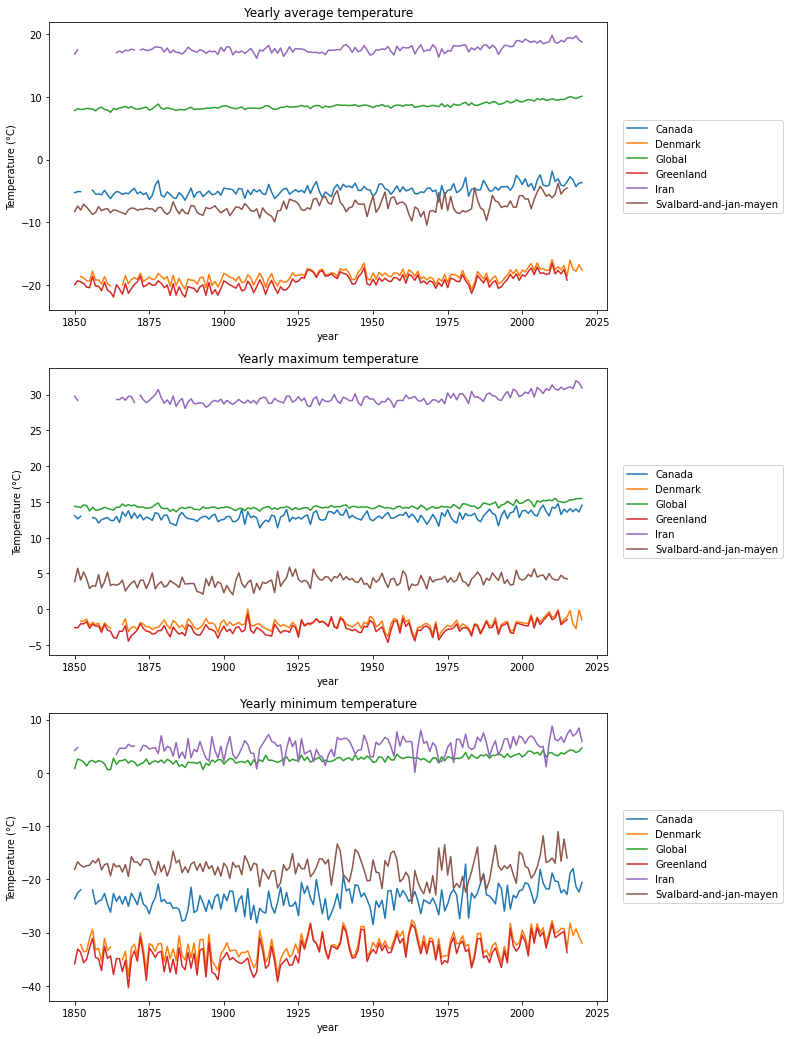

In [15]:
#group by year

fig, ax = plt.subplots(3,1, figsize=(10,18))
tempdata_year1.plot( y="mean_temp", ax=ax[0], title = "Yearly average temperature")
tempdata_year1.plot( y="max_temp", ax=ax[1], title = "Yearly maximum temperature")
tempdata_year1.plot( y="min_temp", ax=ax[2], title = "Yearly minimum temperature")
ax[0].set_ylabel('Temperature (°C)')
ax[1].set_ylabel('Temperature (°C)')
ax[2].set_ylabel('Temperature (°C)')
ax[0].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
ax[1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
ax[2].legend(bbox_to_anchor=(1.02,0.5), loc='center left')

In [16]:
#make plot for each location
tempdata_year2 = tempdata_year[tempdata_year['num_months']==12].reset_index()
tempdata_year2

,year,Location,max_temp,min_temp,mean_temp,num_months
0,1850,Canada,13.098,-23.667,-5.304000,12
1,1850,Denmark,-2.199,-34.079,-19.018583,12
2,1850,Global,14.379,0.796,7.828917,12
3,1850,Greenland,-2.563,-35.845,-20.003917,12
4,1850,Iran,29.772,4.193,16.864417,12
...,...,...,...,...,...,...
993,2019,Iran,31.691,8.387,19.119750,12
994,2020,Canada,14.548,-20.616,-3.696250,12
995,2020,Denmark,-1.478,-31.978,-17.679750,12
996,2020,Global,15.484,4.657,10.116583,12


In [17]:
#group by year and location for Temperature data
#use a function to get the variation max-min for each year
tempdata_year = tempdata.groupby(['year','Location']).agg(
    diff_temp = ('Monthly_temperature', lambda x: (max(x)-min(x))),
    mean_temp=('Monthly_temperature', "mean"),
    num_months=('Monthly_temperature', "count"))

#For the last year with temperature data, 12 month data may not be available, therefore delete 
#all data from that year
tempdata_year3 = tempdata_year[tempdata_year['num_months']==12]
#reset_index() is very useful here
# use unstack() to plot multiple locations on the same plot
tempdata_year3 = tempdata_year3.reset_index()
tempdata_year3

,year,Location,diff_temp,mean_temp,num_months
0,1850,Canada,36.765,-5.304000,12
1,1850,Denmark,31.880,-19.018583,12
2,1850,Global,13.583,7.828917,12
3,1850,Greenland,33.282,-20.003917,12
4,1850,Iran,25.579,16.864417,12
...,...,...,...,...,...
993,2019,Iran,23.304,19.119750,12
994,2020,Canada,35.164,-3.696250,12
995,2020,Denmark,30.500,-17.679750,12
996,2020,Global,10.827,10.116583,12


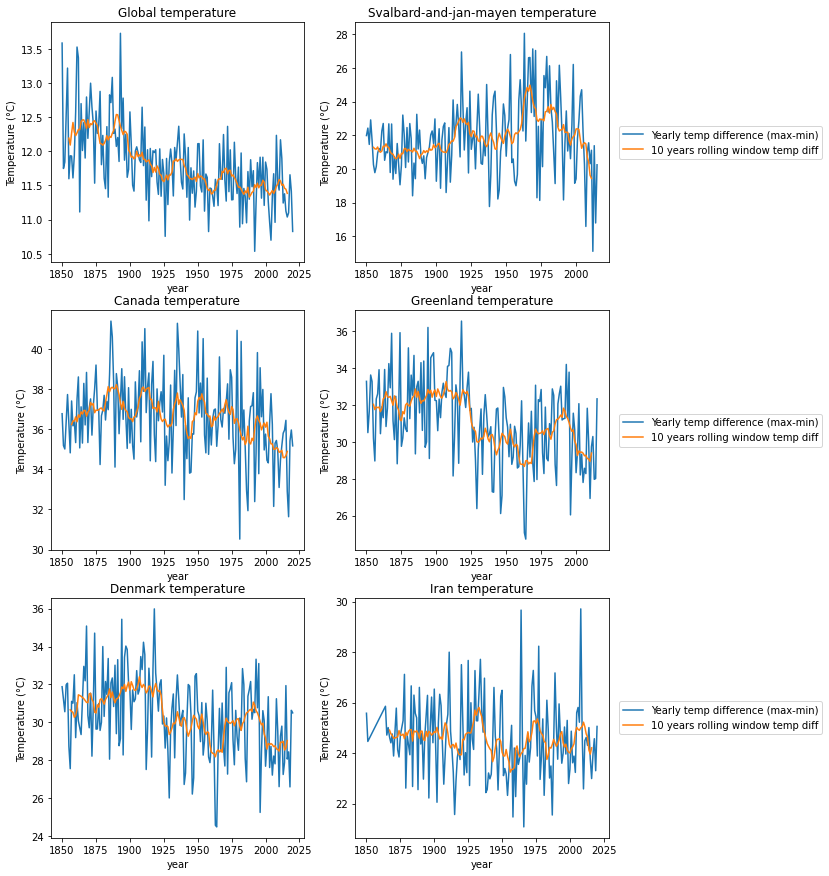

In [18]:
fig, ax = plt.subplots(3,2, figsize=(10,15))
axindex = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
k=0
for location in ['Global','Svalbard-and-jan-mayen','Canada','Greenland','Denmark','Iran']:
    i = axindex[k][0]
    j = axindex[k][1]
    df = tempdata_year3[tempdata_year3['Location']==location]
    df = df.set_index('year')
    df['diff_temp'].plot(ax=ax[i,j], title = location + " temperature", label = 'Yearly temp difference (max-min)')
    df['diff_temp'].rolling(10, center=True).mean().plot(label='10 years rolling window temp diff', ax=ax[i,j])
    ax[i,j].set_ylabel('Temperature (°C)')
    k = k  +1
ax[0,1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
ax[1,1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
ax[2,1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
plt.savefig('temp_by_countries_temp_diff.png',bbox_inches = "tight")

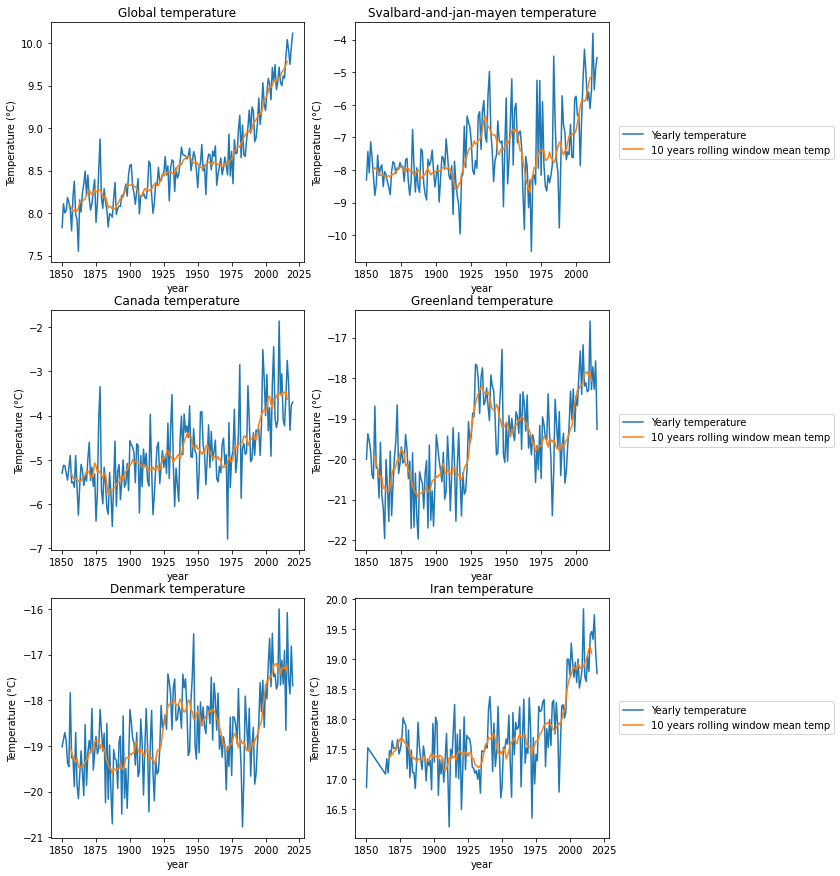

In [19]:
fig, ax = plt.subplots(3,2, figsize=(10,15))
axindex = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
k=0
for location in ['Global','Svalbard-and-jan-mayen','Canada','Greenland','Denmark','Iran']:
    i = axindex[k][0]
    j = axindex[k][1]
    df = tempdata_year3[tempdata_year3['Location']==location]
    df = df.set_index('year')
    df['mean_temp'].plot(ax=ax[i,j], title = location + " temperature", label = 'Yearly temperature')
    df['mean_temp'].rolling(10, center=True).mean().plot(label='10 years rolling window mean temp', ax=ax[i,j])
    ax[i,j].set_ylabel('Temperature (°C)')
    k = k  +1
ax[0,1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
ax[1,1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
ax[2,1].legend(bbox_to_anchor=(1.02,0.5), loc='center left')
plt.savefig('temp_by_countries_average.png',bbox_inches = "tight")

### A.2.2 Get heating rates for each country and the whole world.

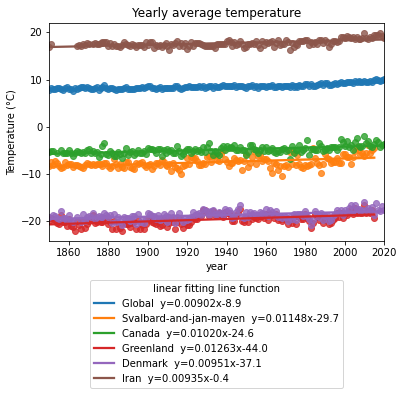

In [35]:
#use seaborn to get linear fitting line for each location temperature
#use linregression to get slope and intercept for legend
slope_list_1850 = []
for location in ['Global','Svalbard-and-jan-mayen','Canada','Greenland','Denmark','Iran']:
    df = tempdata_year3[tempdata_year3['Location']==location]
    #df = df.set_index('year')
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['year'],df['mean_temp'])
    
    slope_list_1850.append(slope)
    ax=sns.regplot(x ='year', y='mean_temp', data=df, 
                   line_kws={'label':location+"  y={0:.5f}x{1:.1f}".format(slope,intercept)})
    ax.set_ylabel('Temperature (°C)')
    ax.legend(bbox_to_anchor=(0.5,-0.7), loc='lower center', title='linear fitting line function')
ax.set_title('Yearly average temperature')
plt.savefig('temp_by_countries_fitting_1850.png',bbox_inches = "tight")

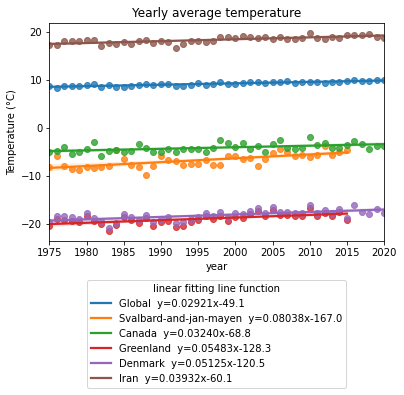

In [36]:
#use seaborn to get linear fitting line for each location temperature
#use linregression to get slope and intercept for legend
slope_list_1975 = []
intercept_list_1975 = []
for location in ['Global','Svalbard-and-jan-mayen','Canada','Greenland','Denmark','Iran']:
    df = tempdata_year3[tempdata_year3['Location']==location]
    df = df[df['year']>=1975]
    #df = df.set_index('year')
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['year'],df['mean_temp'])
    intercept_list_1975.append(intercept)
    slope_list_1975.append(slope)
    ax=sns.regplot(x ='year', y='mean_temp', data=df, 
                   line_kws={'label':location+"  y={0:.5f}x{1:.1f}".format(slope,intercept)})
    ax.set_ylabel('Temperature (°C)')
    ax.legend(bbox_to_anchor=(0.5,-0.7), loc='lower center', title='linear fitting line function')
ax.set_title('Yearly average temperature')
plt.savefig('temp_by_countries_fitting_1975.png',bbox_inches = "tight")



In [24]:
#generate a data frame to the slope of the linear fitting 
slope_df = pd.DataFrame({'linear fitting slope after 1850':pd.Series(slope_list_1850),
                        'linear fitting slope after 1975':pd.Series(slope_list_1975)})
slope_df.index = pd.Series(['Global','Svalbard-and-jan-mayen','Canada','Greenland','Denmark','Iran'])
slope_df

,linear fitting slope after 1850,linear fitting slope after 1975
Global,0.009024,0.029208
Svalbard-and-jan-mayen,0.011481,0.080377
Canada,0.010198,0.032397
Greenland,0.012633,0.054833
Denmark,0.009515,0.051250
Iran,0.009351,0.039317


In [25]:
xs = tempdata_year3[tempdata_year3['Location']=='Global']['year'].values
ys = tempdata_year3[tempdata_year3['Location']=='Global']['mean_temp'].values


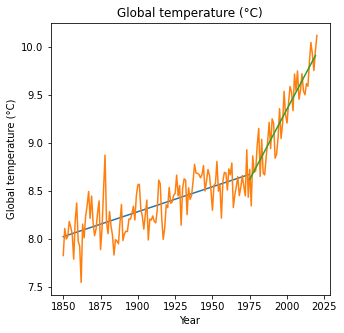

In [26]:
#use linregression to get slope and intercept for data before 1990
slope_list_2 = []
intercept_2 = []
for location in ['Global','Svalbard-and-jan-mayen','Canada','Greenland','Denmark','Iran']:
    df = tempdata_year3[tempdata_year3['Location']==location]
    df = df[df['year']<1975]
    #df = df.set_index('year')
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['year'],df['mean_temp'])
    intercept_2.append(intercept)
    slope_list_2.append(slope)
#make plot for global temperature data with two fitting lines
#there are more advanced techniques,such as numpy piecewise and multisegment fit with ml 
#here just hard code two lines using two slope and intercept pairs from above
x1 = np.arange(1850,1975,1)
x2 = np.arange(1975,2020,1)
y1 = intercept_2[0] + slope_list_2[0] * x1
y2 = intercept_list_1975[0] + slope_list_1975[0] * x2
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.plot( x1, y1)
plt.plot( xs, ys)
plt.plot( x2, y2)

ax.set_ylabel('Global temperature (°C)')
ax.set_xlabel('Year')
ax.set_title('Global temperature (°C)')
plt.savefig('global_temp_fitting.png',bbox_inches = "tight")